In [1]:
# implementation of probabilistic matrix factorisation
# very roughly based off neural net in https://towardsdatascience.com/collaborative-filtering-and-embeddings-part-2-919da17ecefb

%load_ext autoreload
%autoreload 2

from utils import *

import pickle
import random
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz
from tqdm.notebook import tqdm
from itertools import chain
from collections import Counter, defaultdict
from pathlib import Path
from sklearn import metrics
import csv
import datetime
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [2]:
movieid_mid_lookup = get_movieid_mid_lookup(recompute=False)

In [3]:
user_Xs, movie_Xs, ys = get_dataset(train_set, include_ys=True, recompute=False)
user_val_Xs, movie_val_Xs, val_ys = get_dataset(val_set, include_ys=True, recompute=False)
user_test_Xs, movie_test_Xs = get_dataset(test_set, include_ys=False, recompute=False)
movie_genres_one_hot = get_movie_genres_one_hot(recompute=False)

train_genres = get_dataset_genres(train_set, dataset_includes_ys=True, recompute=False)
val_genres = get_dataset_genres(val_set, dataset_includes_ys=True, recompute=False)
test_genres = get_dataset_genres(test_set, dataset_includes_ys=False, recompute=False)

retrieving dataset from dataset/train_ratings_binary.csv
retrieving dataset from dataset/val_ratings_binary.csv
retrieving dataset from dataset/test_ratings.csv


no_genre_count = 0
total = 0

with open(test_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        if movieid_mid_lookup[int(float(rating["movieId"]))] not in movie_genres_one_hot:
            no_genre_count += 1
        total += 1

print(f"{no_genre_count}/{total} entries in the test data doesn't have genre info ({no_genre_count/total}%)")
# all movies in test data accounted for in genre information dataset

In [4]:
# # no memory - implicitly calculating user movie matrix from now on

# movie_embeddings = tf.Variable(tf.random_normal([5, NUM_MOVIES], stddev=0.03, dtype=tf.float32))
# user_embeddings = tf.Variable(tf.random_normal([NUM_USERS, 5], stddev=0.03, dtype=tf.float32))
# movie_bias = tf.Variable(tf.random_normal([1, NUM_MOVIES], stddev=0.03, dtype=tf.float32))
# user_bias = tf.Variable(tf.random_normal([NUM_USERS, 1], stddev=0.03, dtype=tf.float32))

# user_movie_score = tf.tensordot(user_embeddings, movie_embeddings, axes = 1)+.14*tf.tile(movie_bias, [NUM_USERS, 1]) +.87*tf.tile(user_bias, [1, NUM_MOVIES])


In [5]:
# use pca to reduce dimensions with preserved_variance=0.96875 => dim=768 (reduction by 32%), val mse=0.031122472 on scaled data
preserved_variance = 0.95

train_tags = get_tags(movie_Xs, preserved_variance, recompute=False)
val_tags = get_tags(movie_val_Xs, preserved_variance, recompute=False)
test_tags = get_tags(movie_test_Xs, preserved_variance, recompute=False)

NUM_PROJ_TAGS = train_tags[0].shape[0]
print(f"projected down to {NUM_PROJ_TAGS} dims from {NUM_TAGS} dimensions (reduced by {1-NUM_PROJ_TAGS/NUM_TAGS})")

  2%|▏         | 230794/11946576 [00:00<00:05, 2307936.70it/s]

getting tags


  6%|▌         | 224748/3999236 [00:00<00:01, 2247476.78it/s]

getting tags


  5%|▌         | 214765/4054451 [00:00<00:01, 2147641.81it/s]

getting tags


100%|██████████| 4054451/4054451 [00:01<00:00, 2527066.00it/s]

projected down to 646 dims from 1128 dimensions (reduced by 0.4273049645390071)


In [10]:
# the model

embedding_dim = 40

# tags = tf.placeholder(dtype=tf.float32, shape=[None, NUM_PROJ_TAGS])
movie_genre_embeddings = tf.placeholder(dtype=tf.float32, shape=[None, 20])
movie_embeddings = tf.Variable(tf.contrib.layers.xavier_initializer(dtype=tf.float32)([NUM_MOVIES, embedding_dim]))
user_embeddings = tf.Variable(tf.contrib.layers.xavier_initializer(dtype=tf.float32)([NUM_USERS, embedding_dim]))
movie_bias = tf.Variable(tf.random_normal([NUM_MOVIES], stddev=0.03, dtype=tf.float32))
user_bias = tf.Variable(tf.random_normal([NUM_USERS], stddev=0.03, dtype=tf.float32))

user_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
movie_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
user_bias_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
movie_bias_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing

user_embedding_columns = tf.reshape(tf.gather_nd(user_embeddings, user_slice_idxs), [-1, embedding_dim])
movie_embedding_rows = tf.reshape(tf.gather_nd(movie_embeddings, movie_slice_idxs), [-1, embedding_dim])
print("movie_embedding_rows shape", movie_embedding_rows.shape)

user_slice_bias = tf.reshape(tf.gather_nd(user_bias, user_slice_idxs), [-1, 1])
movie_slice_bias = tf.reshape(tf.gather_nd(movie_bias, movie_slice_idxs), [-1, 1])
# print("user_slice_bias shape", user_slice_bias.shape)

# print((user_embedding_columns * tf.concat((movie_embedding_rows, movie_genre_embeddings), axis=1)).shape)
# print(movie_slice_bias.shape)
# print(user_slice_bias".shape)

mult_input = movie_embedding_rows * user_embedding_columns
input_layer = tf.concat((
#     tags,
    mult_input,
    movie_embedding_rows,
    movie_genre_embeddings,
    user_embedding_columns,
    user_slice_bias,
    movie_slice_bias), axis=1)
print(movie_embedding_rows.shape, user_embedding_columns.shape, user_slice_bias.shape)
print("input layer shape", input_layer.shape)

W1 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[int(input_layer.shape[1]), 40], dtype=tf.float32))
b1 = tf.Variable(initial_value=np.zeros(shape=[40], dtype=np.float32))
l1 = tf.nn.relu(tf.matmul(input_layer, W1) + b1)

W2 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[40, 20], dtype=tf.float32))
b2 = tf.Variable(initial_value=np.zeros(shape=[20], dtype=np.float32))
l2 = tf.nn.relu(tf.matmul(l1, W2) + b2)

W3 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[20, 2], dtype=tf.float32))
b3 = tf.Variable(initial_value=np.zeros(shape=[2], dtype=np.float32))
pred_y =tf.nn.sigmoid(tf.matmul(l2, W3) + b3)

print("pred_y shape", pred_y.shape)

# embedding_pred_vectors = tf.reshape(tf.reduce_sum(user_embedding_columns * tf.concat((movie_embedding_rows, movie_genre_embeddings), axis=1), axis=1), (-1, 1))
# pred_y = embedding_pred_vectors + .14*movie_slice_bias + .87*user_slice_bias
# print(embedding_pred_vectors.shape)
# print(pred_y.shape)

y_true = tf.placeholder(dtype=tf.float32, shape=[None, 2])


movie_embedding_rows shape (?, 40)
(?, 40) (?, 40) (?, 1)
input layer shape (?, 142)
pred_y shape (?, 2)


In [12]:
plot_weights = True

def run_expr(learning_rate=.05, epochs=60):
#     l2_loss_term = .0001 * sum([tf.reduce_sum(tf.reshape(weight*weight, [-1])) for weight in all_weights])
    mse_loss_term = tf.reduce_mean(tf.squared_difference(pred_y, y_true))
    ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
    loss = mse_loss_term
    # + l2_loss_term
    train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    init = tf.global_variables_initializer()

    flat_val_ys = [(1 if y[0] > y[1] else 0) for y in val_ys]

    min_acc_auc = (math.inf, math.inf)
    
    with tf.Session() as sess:
        sess.run(init)

        for epoch in tqdm(range(epochs), leave=False):
            feed_dict = {tags: train_tags,
                         user_slice_idxs: user_Xs, 
                         movie_slice_idxs: movie_Xs, 
                         movie_genre_embeddings: train_genres,
                         y_true: ys}
            print("training")
            outs = (train_step, loss, pred_y[:5], mse_loss_term)
            _, lossval, pred_y_val, mse_loss_term_val = sess.run(outs, feed_dict=feed_dict)
            print("train loss", lossval, "pred_ys", pred_y_val, "true_ys", ys[:5])

            feed_dict = {tags: val_tags,
                        user_slice_idxs: user_val_Xs, 
                        movie_slice_idxs: movie_val_Xs,
                        movie_genre_embeddings: val_genres,
                        y_true: val_ys}
            val_y_pred, val_loss_val = sess.run((pred_y, loss), feed_dict=feed_dict)
            flat_pred_y_floats = [y[0]/(y[0]+y[1]) for y in val_y_pred]
            flat_pred_y_bools = [(1 if y[0] > y[1] else 0) for y in val_y_pred]
            
            print("val loss", val_loss_val)
            acc = metrics.accuracy_score(flat_val_ys, flat_pred_y_bools)
            fpr, tpr, _ = metrics.roc_curve(flat_val_ys, flat_pred_y_floats)
            auc = metrics.auc(fpr, tpr)
            min_acc_auc = min(min_acc_auc, (acc, auc))
        if plot_weights:
            print("plotting")
#                 plt.hist(sess.run(mult_input, feed_dict))
            mult_inputs = sess.run(mult_input, feed_dict), 

            pred_ys = sess.run(pred_y, feed_dict)

            mult_input_pos = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] > pred[1]]).flatten()
            if len(mult_input_pos) > 0:
                print("avg pos", sum(mult_input_pos)/len(mult_input_pos), "pos ct", len(mult_input_pos))
            else:
                print(mult_input_pos)
            mult_input_neg = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] <= pred[1]]).flatten()
            if len(mult_input_neg) > 0:
                print("avg neg", sum(mult_input_neg)/len(mult_input_neg), "neg ct", len(mult_input_neg))
            else:
                print("mult_input_neg", mult_input_neg)
            
            plt.title("pos inputs")
            plt.hist(mult_input_pos)
            plt.show()
            plt.title("neg inputs")
            plt.hist(mult_input_neg)
            plt.show()
            
    return min_acc_auc

In [45]:
min_overall_score = (math.inf, math.inf)
experiment_scores = {}
# experiments = zip([.1, .07, .06, .05, .04, .03, .01], [40] * 100)
experiments = zip([.04], [40] * 100)

for lr, epochs in tqdm(list(experiments)):
    try:
        score = run_expr(lr, epochs)
        min_overall_score = min(min_overall_score, score)
        experiment_scores[lr] = score
    except Exception as e:
        print(e)
        pass

print(min_overall_score)
print(experiment_scores)


KeyboardInterrupt: 

In [ ]:
try:
    sess
except NameError:
    pass
else:
    sess.close()

sess = tf.Session() # we don't want to close the session

learning_rate=.07
epochs=50
#     l2_loss_term = .0001 * sum([tf.reduce_sum(tf.reshape(weight*weight, [-1])) for weight in all_weights])
mse_loss_term = tf.reduce_mean(tf.squared_difference(pred_y, y_true))
ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
loss = mse_loss_term
# + l2_loss_term
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

flat_val_ys = [(1 if y[0] > y[1] else 0) for y in val_ys]

min_acc_auc = (math.inf, math.inf)

sess.run(init)

val_accs = []
val_aucs = []

# tensorboard doesn't work with tensorflow 1 anymore... 
# ill fucking switch to pytorch before touching tf2
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
# train_file_writer = tf.summary.FileWriter(train_log_dir, sess.graph)
# test_file_writer = tf.summary.FileWriter(test_log_dir, sess.graph)

with open("prev_run_stats.pickle", "rb") as prev_run_file:
    _, prev_run_scores, _, prev_best_auc_run = pickle.load(prev_run_file)
    _, prev_best_aucs = prev_run_scores[prev_best_auc_run]

for epoch in tqdm(range(epochs), leave=False):
    print("epoch", epoch)
    print("training")    
#     for b_tags, b_user_Xs, b_movie_Xs, b_genres, b_ys in batchify(train_tags, user_Xs, movie_Xs, train_genres, ys, batch_size=995548, shuffle=False):
    feed_dict = {user_slice_idxs: user_Xs, 
                 movie_slice_idxs: movie_Xs, 
                 movie_genre_embeddings: train_genres,
#                  tags: b_tags,
                 y_true: ys}
    outs = (train_step, loss, pred_y[:5])
    _, lossval, pred_y_val = sess.run(outs, feed_dict=feed_dict)
#         print("pred_ys", pred_y_val, "true_ys", b_ys[:5])
    print("train loss", lossval)

#         with train_file_writer as writer:
#             writer.add_summary(tf.summary.scalar("loss", loss))

    feed_dict = {user_slice_idxs: user_val_Xs, 
                movie_slice_idxs: movie_val_Xs,
                movie_genre_embeddings: val_genres,
#                 tags: val_tags,
                y_true: val_ys}
    val_y_pred, val_loss_val = sess.run((pred_y, loss), feed_dict=feed_dict)
    flat_pred_y_floats = [y[0]/(y[0]+y[1]) for y in val_y_pred]
    flat_pred_y_bools = [(1 if y[0] > y[1] else 0) for y in val_y_pred]


    print("val loss", val_loss_val)
    acc = metrics.accuracy_score(flat_val_ys, flat_pred_y_bools)
    fpr, tpr, _ = metrics.roc_curve(flat_val_ys, flat_pred_y_floats)
    auc = metrics.auc(fpr, tpr)
    print("val acc", acc, "val auc", auc)
    min_acc_auc = min(min_acc_auc, (acc, auc))
    val_accs.append(acc)
    val_aucs.append(auc)
    
    plt.clf()
    plt.title("val aucs per epoch")
    plt.plot(prev_best_aucs, marker='o', color="grey")
    plt.plot(val_aucs, marker='o', color="black")
    plt.savefig("cur_val_aucs.png")
    
#     with test_file_writer as writer:
#         writer.add_summary(value=[tf.summary.Value(tag="loss", simple_value=val_loss_val)])
#         writer.add_summary(tf.summary.scalar("loss", loss))
#         writer.add_summary(value=[tf.summary.Value(tag="acc", simple_value=acc)])
#         writer.add_summary(value=[tf.summary.Value(tag="auc", simple_value=auc)])



epoch 0
training
train loss 0.25282305
val loss 0.267319
val acc 0.5171700294756298 val auc 0.5352009873692812
epoch 1
training
train loss 0.272101
val loss 0.23816071
val acc 0.6355678934676523 val auc 0.6879839688265318
epoch 2
training
train loss 0.23357986
val loss 0.2220021
val acc 0.6660802213222725 val auc 0.7296670910500562
epoch 3
training
train loss 0.21311893
val loss 0.20636801
val acc 0.6816061867816753 val auc 0.7470892292284769
epoch 4
training
train loss 0.1962951
val loss 0.20505121
val acc 0.6880116602271034 val auc 0.7613870442723754
epoch 5
training
train loss 0.19286156
val loss 0.20079342
val acc 0.696845097413606 val auc 0.7681926214943051
epoch 6
training
train loss 0.18640096
val loss 0.19826701
val acc 0.7001337255415785 val auc 0.7708051333574822
epoch 7
training
train loss 0.18344074
val loss 0.19516
val acc 0.7030115252013135 val auc 0.7739895804343615
epoch 8
training
train loss 0.18192983
val loss 0.19285758
val acc 0.7052071945741637 val auc 0.7767561405

In [ ]:
# im reduced to manually tensorboarding like a loser cause tf2 api is being a dick not my fault

with open("prev_run_stats.pickle", "rb") as prev_run_file:
    cur_run, run_scores, best_auc, best_auc_run = pickle.load(prev_run_file)

run_scores[cur_run] = (val_accs, val_aucs)
if max(val_aucs) > best_auc:
    best_auc, best_auc_run = val_aucs[-1], cur_run

cur_run += 1
best_accs, best_aucs = run_scores[best_auc_run]

with open("prev_run_stats.pickle", "wb+") as prev_run_file:
    pickle.dump((cur_run, run_scores, best_auc, best_auc_run), prev_run_file)

plt.title("val accs per epoch")
plt.plot(best_accs, marker='o', color="grey")
plt.plot(val_accs, marker='o', color="black")
plt.show()

plt.title("val aucs per epoch")
plt.plot(best_aucs, marker='o', color="grey")
plt.plot(val_aucs, marker='o', color="black")
plt.show()

print(f"best run: {best_auc_run}")

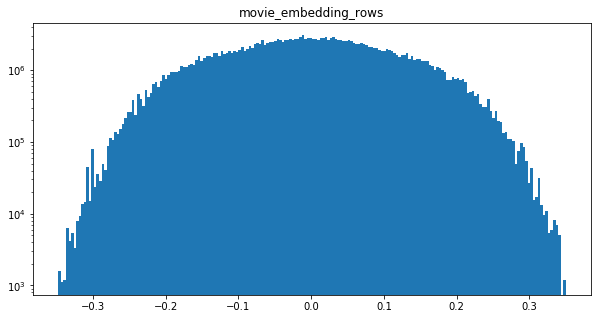

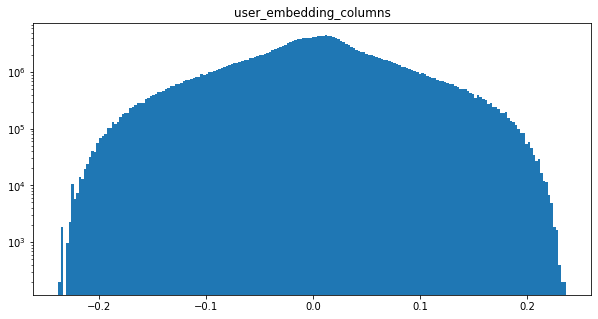

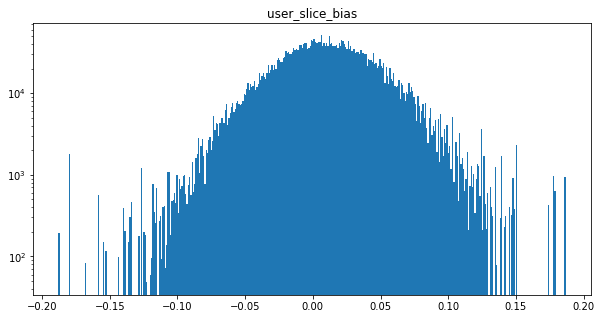

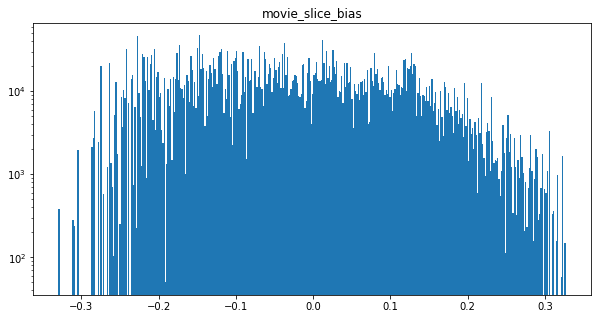

In [39]:
plt.rc('figure', figsize=(10, 5))
plt.title("movie_embedding_rows")
plt.hist(sess.run(movie_embedding_rows, feed_dict).flatten(), log=True, bins=200)
plt.show()
plt.title("user_embedding_columns")
plt.hist(sess.run(user_embedding_columns, feed_dict).flatten(), log=True, bins=200)
plt.show()
plt.title("user_slice_bias")
plt.hist(sess.run(user_slice_bias, feed_dict).flatten(), log=True, bins=400)
plt.show()
plt.title("movie_slice_bias")
plt.hist(sess.run(movie_slice_bias, feed_dict).flatten(), log=True, bins=400)
plt.show()
# movie embedding and user embedding look like textbook normal distributions makes sense yepp
# user biases look like some sort of bimodal distribution?????
# and why are movie slice biases so chaotic

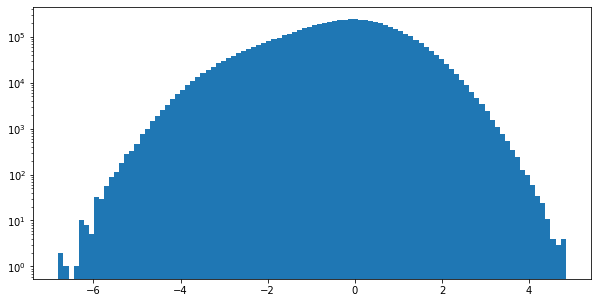

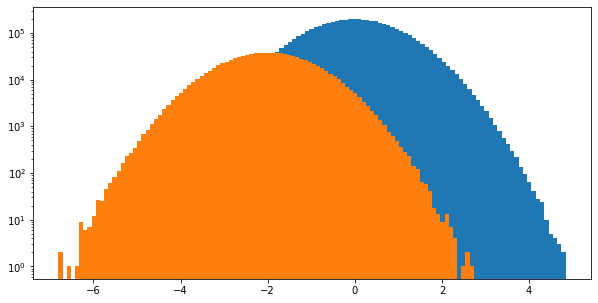

In [136]:
mode1 = np.random.normal(0, 1, 5000000)
mode2 = np.random.normal(-2, 1, 1000000)

plt.hist(np.concatenate((mode1, mode2)), bins=100, log=True)
plt.show()
plt.hist(mode1, bins=100, log=True)
plt.hist(mode2, bins=100, log=True)
plt.show()


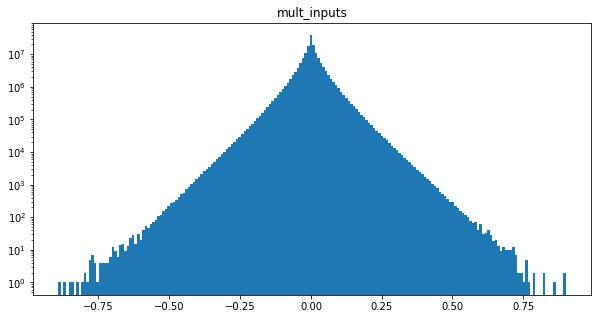

avg pos -0.00035934525807793615 pos ct 75741520
avg neg 0.0005471634820769635 neg ct 84227920


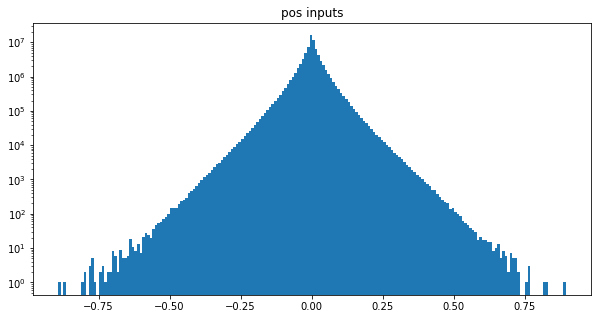

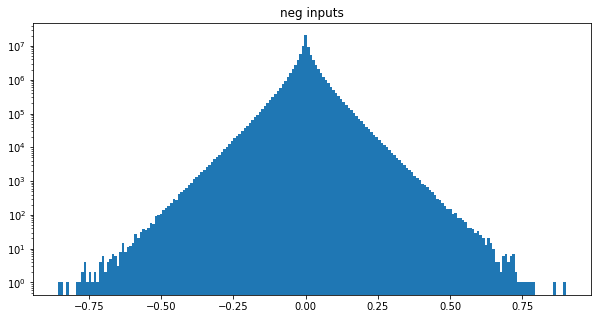

In [127]:
mult_inputs = sess.run(mult_input, feed_dict)
plt.cla()
plt.title("mult_inputs")
plt.hist(mult_inputs.flatten(), log=True, bins=200)
plt.show()

pred_ys = sess.run(pred_y, feed_dict)

mult_input_pos = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] > pred[1]]).flatten()
if len(mult_input_pos) > 0:
    print("avg pos", sum(mult_input_pos)/len(mult_input_pos), "pos ct", len(mult_input_pos))
else:
    print("mult_input_pos", mult_input_pos)

mult_input_neg = np.array([mult_input for mult_input, pred in zip(mult_inputs, pred_ys) if pred[0] <= pred[1]]).flatten()
if len(mult_input_neg) > 0:
    print("avg neg", sum(mult_input_neg)/len(mult_input_neg), "neg ct", len(mult_input_neg))
else:
    print("mult_input_neg", mult_input_neg)

plt.title("pos inputs")
plt.hist(mult_input_pos, bins=200, log=True)
plt.show()
plt.title("neg inputs")
plt.hist(mult_input_neg, bins=200, log=True)
plt.show()

# makes sense why these are basically chi square - composed of normal distributions multiplied together which is fundamentally what we're predicting